# INF0616 - Aula 4: construindo uma rede simples com o Keras

Escrito por **Xavier Snelgrove** ([link to his GitHub](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb)), com pequenas modificações de **Rafael Padilha**.

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br


Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/469](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=469)

Instituto de Computação - Unicamp 2022


-----------

**This is a simple tutorial on working with neural networks in Keras. In this exercise, we will define, train and evaluate a simple feed-forward NN to classify handwritten digits.**

In [ ]:
import numpy as np
from random import shuffle, seed
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input
from keras.utils import np_utils
from keras import optimizers

plt.rcParams['figure.figsize'] = (32,32) # Make the figures a bit bigger
seed(42)

%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

nb_classes = 10

# Os dados são carregados já embaralhados e separados em treino e teste.
(trainVal_data, trainVal_label), (X_test, y_test) = mnist.load_data()

# Separamos trainVal em treino e validação.
(X_train, X_val, y_train, y_val) = train_test_split(trainVal_data, trainVal_label,
                                                    test_size=0.2)
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape), "\n"

print("X_val original shape", X_val.shape)
print("y_val original shape", y_val.shape), "\n"

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train original shape (48000, 28, 28)
y_train original shape (48000,)
X_val original shape (12000, 28, 28)
y_val original shape (12000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


Let's look at some examples of the training data:

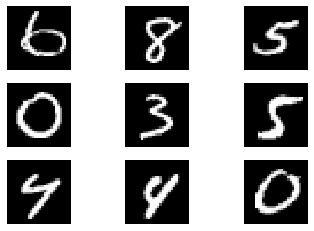

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.axis('off')

## O quão balanceado é o nosso treinamento?
Vamos encontrar quantas amostras estão contidas em cada classe e calular o peso das classes a partir disso. Isso é útil para dizer ao modelo que "preste mais atenção" em amostras sub-representadas, durante treinamento.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique(y_train, return_counts=True)
print ("Train ---> ", dict(zip(unique, counts)), "\n")

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
train_class_weights = dict(enumerate(class_weights))
print (train_class_weights, "\n")

Train --->  {0: 4742, 1: 5394, 2: 4779, 3: 4907, 4: 4668, 5: 4341, 6: 4707, 7: 5006, 8: 4682, 9: 4774} 

{0: 1.0122311261071277, 1: 0.8898776418242491, 2: 1.0043942247332078, 3: 0.9781944161402079, 4: 1.0282776349614395, 5: 1.10573600552868, 6: 1.0197578075207139, 7: 0.9588493807431082, 8: 1.0252029047415634, 9: 1.0054461667364893} 



Para o conjunto de teste, usaremos isso para encontrar a acurácia balanceada:

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
print("Test ---> ", dict(zip(unique, counts)), "\n")

test_sample_per_class = counts

Test --->  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009} 



## Preprocessamento
Nossa rede irá receber um único vetor para cada exemplo no conjunto, então precisamos "reformatar" o conjunto para que cada imagem de $28\times 28$ se transforme em um único vetor de 784 dimensões. Iremos também escalar os valores para que fiquem no intervalo $[0, 1]$ em vez de $[0, 255]$.

In [ ]:
size = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], size)
X_val = X_val.reshape(X_val.shape[0], size)
X_test = X_test.reshape(X_test.shape[0], size)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (48000, 784)
Validation matrix shape (12000, 784)
Testing matrix shape (10000, 784)


Vamos modificar o vetor de rótulos para o formato *one-hot encoded*. Isto é:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
...
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 1]
```

In [ ]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print("Training matrix shape", Y_train.shape)
print("Testing matrix shape", Y_test.shape)

Training matrix shape (48000, 10)
Testing matrix shape (10000, 10)


In [ ]:

print(Y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# Construíndo a rede
Aqui faremos uma simples rede com 4 camadas (input + duas camadas escondidas + saída), usando camadas densas (ou totalmente-conexas). Neste tipo de camada, cada unidade está conectado à cada unidade na camada anterioro. Se considerarmos a primeira camada escondida, cada unidade está conectada à cada pixel da imagem de entrada.
<img src="figure.png" />

Há duas formas de se instanciar redes em Keras. Uma delas é instanciando um modelo `Sequential` com uma lista de camadas. A primeira camada da rede precisa receber o parâmetro `input_shape` para que o modelo saiba calcular o número de parâmetros. 

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Porém, a forma mais comum é utilizando a API funcional do Keras:

In [ ]:
ipt = Input(shape = (784,))
x = Dense(512, activation='relu')(ipt)
y = Dense(512, activation='relu')(x)
out = Dense(10, activation='softmax')(y)

model = Model(inputs=ipt, outputs=out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


## Compile o modelo
Keras é construido sobre o Tensorflow, Theano ou CNTK, bibliotecas de computação que permitem a utilização de diferentes dispositivos (ex.: CPU, GPU, nós em uma rede) de forma transparente e eficiente.

Quando compilando um modelo, Keras requer que você especifique uma **função de perda**, seu **otimizador** e algumas **métricas**. A função de perda que usaremos aqui é chamada de *categorical crossentropy*, e é a função mais adequada para comparar duas distribuições de probabilidade.

Aqui nossas predições são distribuições de probabilidade de 10 diferentes dígitos (ex: "estamos 80% confiante que esta imagem é um 3, 10% confiante que é um 8, 5% um 2 etc"), e o alvo é a probabilidade de 100% para a categoria correta e 0% para todas as demais. A *cross-entropy* é a medida do quão diferente sua distribuição de predição é da distribuição alvo. [Veja mais na Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

O [otimizador](https://keras.io/optimizers) ajuda a determinar o quão rápido um modelo aprende, quão resiliente ele será à "estagnação" ou "explosão" durante o treinamento. Neste exercício, utilizaremos uma variação do gradiente descendente chamado **Stocastic Gradient Descent (SGD)**. Em vez de considerar todo o conjunto de treinamento a cada iteração, o SGD somente utiliza uma pequena amostra aleatória dos dados disponíveis a cada vez.

Além disso, podemos definir um número de métricas (como acurácia, MSE, MAE) para observar durante o treinamento. **Entretanto, Keras não se utiliza da acurácia balanceada!**

In [ ]:
sgd = optimizers.SGD(lr=0.01) #lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

## Treine seu modelo!
Essa é a parte divertida: você pode alimentar seu modelo com os dados de treino carregados anteriormente e ele aprenderá a classificar digitos!

Primeiro, vamos entender os argumentos:
- **X_train & Y_train:** as amostras e rótulos de treino
- **batch_size:** em vez de otimizar os parâmetros da rede sobre todo o conjunto de treino, nós usualmente atualizamos a cada *batch* (pequenas amostras do conjunto de treino). Neste caso, vamos atualizar nossos pesos (*backpropagation*) a cada 128 imagens
- **epochs:** uma época na qual todos os *batches* contidos no conjunto de treino foram processados. Diremos que o conjunto de dados será processado 8 vezes
- **verbose:** mostrar as métricas ao fim de cada época
- **class_weight:** os pesos de cada classe, considerando que elas não são balanceadas. Isso irá ponderar a perda baseando-se em quão frequente cada classe é
- **validation_data:** ao final de cada época, nosso modelo é utilizado para predizer este conjunto e exibir o valor de perda e métricas especificadas.

In [ ]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=8, verbose=1,
          class_weight = train_class_weights, 
          validation_data=(X_val, Y_val))

Epoch 1/8
375/375 [==============================] - 5s 13ms/step - loss: 1.2591 - accuracy: 0.7324 - val_loss: 0.6392 - val_accuracy: 0.8547
Epoch 2/8
375/375 [==============================] - 5s 13ms/step - loss: 0.5140 - accuracy: 0.8738 - val_loss: 0.4346 - val_accuracy: 0.8852
Epoch 3/8
375/375 [==============================] - 5s 13ms/step - loss: 0.3952 - accuracy: 0.8953 - val_loss: 0.3707 - val_accuracy: 0.8961
Epoch 4/8
375/375 [==============================] - 5s 12ms/step - loss: 0.3458 - accuracy: 0.9047 - val_loss: 0.3364 - val_accuracy: 0.9059
Epoch 5/8
375/375 [==============================] - 5s 12ms/step - loss: 0.3156 - accuracy: 0.9129 - val_loss: 0.3136 - val_accuracy: 0.9119
Epoch 6/8
375/375 [==============================] - 5s 13ms/step - loss: 0.2939 - accuracy: 0.9174 - val_loss: 0.2968 - val_accuracy: 0.9153
Epoch 7/8
375/375 [==============================] - 5s 13ms/step - loss: 0.2764 - accuracy: 0.9228 - val_loss: 0.2845 - val_accuracy: 0.9186
Epoch 

## Finalmente, avaliamos a performance sobre um conjunto de teste

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT BALANCED):', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.2496 - accuracy: 0.9313
Test loss: 0.24962471425533295
Test accuracy (NOT BALANCED): 0.9312999844551086


## Acurácia Balanceada

In [ ]:
# O método predict retorna o vetor softmax com as probabilidades de cada classe.
probs = model.predict(X_test)
print("Probs = ", probs[0,:])
predicted_classes = np.argmax(probs, axis=-1)
print("Class = ", predicted_classes[0])

Probs =  [1.10206682e-04 2.87747497e-07 1.96007837e-04 1.17213081e-03
 3.39123631e-06 9.89262771e-05 1.15086536e-07 9.97585773e-01
 3.57726603e-05 7.97534420e-04]
Class =  7


In [ ]:
# Calcular a classe correta, utilizando o vetor `one-hot encoded`
# que contém as classes referentes às amostras de teste.
Y_test_classes = np.argmax(Y_test, axis=-1)

accPerClass = []
for classIdx in range(nb_classes):
    idx = (Y_test_classes == classIdx)
    
    correctPred = np.sum(predicted_classes[idx] == Y_test_classes[idx])
    accPerClass.append( correctPred / float(test_sample_per_class[classIdx]))
    
print (dict(zip(range(nb_classes),accPerClass)), "\n")
print ("Balanced Acc --> ", np.mean(accPerClass))

{0: 0.9795918367346939, 1: 0.9762114537444934, 2: 0.9098837209302325, 3: 0.9089108910891089, 4: 0.9348268839103869, 5: 0.922645739910314, 6: 0.9498956158663883, 7: 0.9231517509727627, 8: 0.8993839835728953, 9: 0.9038652130822596} 

Balanced Acc -->  0.9308367089813535


### Inspecionando a saída

É sempre uma boa ideia inspecionar a saída e verificar que tudo parece adequado. Aqui, iremos olhar para alguns exemplos que o modelo acerta e alguns que ele erra.

In [ ]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Determina os índices das amostras que foram preditas corretamente/incorretamente
correct_indices, = np.where(predicted_classes == y_test)
incorrect_indices, = np.where(predicted_classes != y_test)

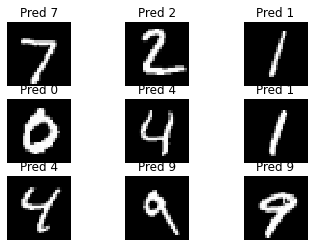

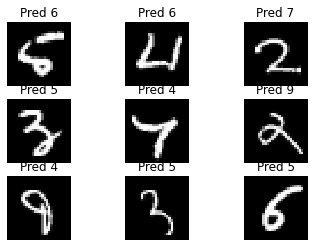

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Pred {}".format(predicted_classes[correct]))
    plt.axis('off')

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Pred {}".format(predicted_classes[incorrect]))
    plt.axis('off')

# Referencias

Existem vários outros ótimos exemplos na página do Keras http://keras.io e em seu código-fonte https://github.com/keras-team/keras. Além desses, este notebook foi adaptado [daqui](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb).